In [1]:
from csv import DictReader

with open('_data/properties_master.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

In [2]:
properties_to_use = [
    'properties.cetane_number.value',
    'properties.ysi_unified.value'
]

samples = []
for row in rows:
    use = True
    for prop in properties_to_use:
        if row[prop] == '-':
            use = False
            break
    if use:
        samples.append(row)

print(len(samples))

150


In [3]:
import numpy as np
from sklearn.preprocessing import RobustScaler

data_cn = np.array([float(s['properties.cetane_number.value']) for s in samples]).reshape(-1, 1)
data_ysi = np.array([float(s['properties.ysi_unified.value']) for s in samples]).reshape(-1, 1)
smiles = [s['canonical_smiles'] for s in samples]

print(min(data_cn), max(data_cn))
print(min(data_ysi), max(data_ysi))

[-7.] [160.]
[6.6] [774.5]


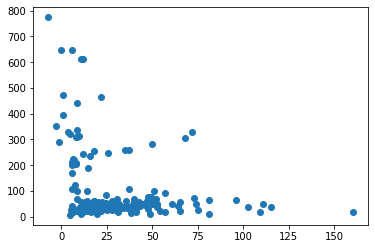

In [4]:
from matplotlib import pyplot as plt

plt.scatter(data_cn, data_ysi)
plt.show()

In [5]:
import numpy as np

print(np.mean(data_cn), np.std(data_cn))
print(np.mean(data_ysi), np.std(data_ysi))

30.885333333333328 26.15231127240743
111.81066666666666 146.08509718501597


In [6]:
cn_mean = np.mean(data_cn)
cn_std = np.std(data_cn)

ysi_mean = np.mean(data_ysi)
ysi_std = np.std(data_ysi)

# cn_lower_bounds, cn_upper_bounds = cn_mean - 2 * cn_std, cn_mean + 2 * cn_std
# ysi_lower_bounds, ysi_upper_bounds = ysi_mean - 1 * ysi_std, ysi_mean + 0.3 * ysi_std
cn_lower_bounds, cn_upper_bounds = 0, 100
ysi_lower_bounds, ysi_upper_bounds = 0, 100

smiles_to_use = []
cn_to_use = []
ysi_to_use = []

for i in range(len(smiles)):

    if data_cn[i] > cn_lower_bounds and data_cn[i] < cn_upper_bounds:
        if data_ysi[i] > ysi_lower_bounds and data_ysi[i] < ysi_upper_bounds:
            smiles_to_use.append(smiles[i])
            cn_to_use.append(data_cn[i])
            ysi_to_use.append(data_ysi[i])

print(len(smiles_to_use), len(cn_to_use), len(ysi_to_use))

106 106 106


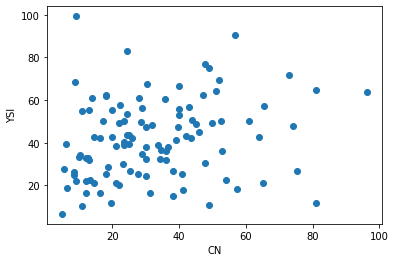

In [7]:
plt.clf()
plt.xlabel('CN')
plt.ylabel('YSI')
plt.scatter(cn_to_use, ysi_to_use)
plt.show()

In [8]:
from scipy.stats import spearmanr, pearsonr

print(spearmanr([c[0] for c in cn_to_use], [y[0] for y in ysi_to_use]), pearsonr([c[0] for c in cn_to_use], [y[0] for y in ysi_to_use]))

SpearmanrResult(correlation=0.2478856635508779, pvalue=0.01040722287305897) (0.215349403569841, 0.02662655456184195)


In [9]:
from ecnet.datasets import QSPRDataset, QSPRDatasetFromValues
from sklearn.model_selection import train_test_split
import torch

cn_train, cn_test, ysi_train, ysi_test, smiles_train, smiles_test = train_test_split(cn_to_use, ysi_to_use, smiles_to_use, test_size=0.2, random_state=42)
targets_train = np.concatenate((cn_train, ysi_train), axis=1)
targets_test = np.concatenate((cn_test, ysi_test), axis=1)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')

ds_train_cn = QSPRDatasetFromValues(ds_train.desc_vals, cn_train)
ds_test_cn = QSPRDatasetFromValues(ds_test.desc_vals, cn_test)

ds_train_ysi = QSPRDatasetFromValues(ds_train.desc_vals, ysi_train)
ds_test_ysi = QSPRDatasetFromValues(ds_test.desc_vals, ysi_test)

DESC_VALS = torch.cat((ds_train.desc_vals, ds_test.desc_vals))
TARG_VALS = torch.cat((ds_train.target_vals, ds_test.target_vals))

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(ds_train.desc_vals.detach().numpy())

ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

# all datasets have the same samples, only target values differ
ds_train_cn.desc_vals = ds_train.desc_vals
ds_test_cn.desc_vals = ds_test.desc_vals
ds_train_ysi.desc_vals = ds_train.desc_vals
ds_test_ysi.desc_vals = ds_test.desc_vals

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)
print(ds_train_cn.desc_vals.shape, ds_test_cn.desc_vals.shape)
print(ds_train_ysi.desc_vals.shape, ds_test_ysi.desc_vals.shape)

# TODO: typecast within QSPRDataset to prevent float32 vs. double errors
ds_train.target_vals = ds_train.target_vals.type(torch.float32)
ds_test.target_vals = ds_test.target_vals.type(torch.float32)
ds_train_cn.target_vals = ds_train_cn.target_vals.type(torch.float32)
ds_test_cn.target_vals = ds_test_cn.target_vals.type(torch.float32)
ds_train_ysi.target_vals = ds_train_ysi.target_vals.type(torch.float32)
ds_test_ysi.target_vals = ds_test_ysi.target_vals.type(torch.float32)

torch.Size([84, 84]) torch.Size([22, 84])
torch.Size([84, 84]) torch.Size([22, 84])
torch.Size([84, 84]) torch.Size([22, 84])


In [11]:
from ecnet import ECNet

model = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 3)
model_cn = ECNet(ds_train_cn.desc_vals.shape[1], ds_train_cn.target_vals.shape[1], 512, 3)
model_ysi = ECNet(ds_train_ysi.desc_vals.shape[1], ds_train_ysi.target_vals.shape[1], 512, 3)

In [12]:
print('CN/YSI...')
train_loss, _ = model.fit(dataset=ds_train, epochs=256, valid_size=0.33, shuffle=True, patience=16, verbose=15, lr=0.001)
print('CN...')
train_loss_cn, _ = model_cn.fit(dataset=ds_train_cn, epochs=256, shuffle=True, valid_size=0.16, patience=32, verbose=15, lr=0.001)
print('YSI...')
train_loss_ysi, _ = model_ysi.fit(dataset=ds_train_ysi, epochs=256, shuffle=True, valid_size=0.33, patience=16, verbose=15, lr=0.001)

CN/YSI...
Epoch: 0 | Train loss: 1652.23388671875 | Valid loss: 9223372036854775807
Epoch: 15 | Train loss: 214.95847647530692 | Valid loss: 247.95895385742188
Epoch: 30 | Train loss: 88.4143556867327 | Valid loss: 66.94405364990234
Epoch: 45 | Train loss: 22.507891246250697 | Valid loss: 28.391834259033203
Epoch: 60 | Train loss: 8.342958586556572 | Valid loss: 5.470149040222168
Epoch: 75 | Train loss: 4.089459964207241 | Valid loss: 4.181137561798096
Epoch: 90 | Train loss: 1.1094124742916651 | Valid loss: 0.6825426816940308
Epoch: 105 | Train loss: 1.245147364480155 | Valid loss: 0.4524402618408203
Epoch: 120 | Train loss: 0.7457589762551444 | Valid loss: 0.5673273801803589
CN...
Epoch: 0 | Train loss: 1215.8357561383928 | Valid loss: 9223372036854775807
Epoch: 15 | Train loss: 241.70175410679408 | Valid loss: 265.9616394042969
Epoch: 30 | Train loss: 39.9043571472168 | Valid loss: 116.22095489501953
Epoch: 45 | Train loss: 84.77469308035714 | Valid loss: 141.635009765625
Epoch: 60 

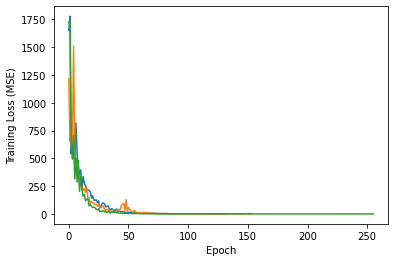

In [13]:
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.plot([i for i in range(len(train_loss))], train_loss, label='CN/YSI')
plt.plot([i for i in range(len(train_loss_cn))], train_loss_cn, label='CN')
plt.plot([i for i in range(len(train_loss_ysi))], train_loss_ysi, label='YSI')
plt.show()

In [14]:
preds_train = model(ds_train.desc_vals).detach().numpy()
preds_test = model(ds_test.desc_vals).detach().numpy()

preds_train_cn = model_cn(ds_train_cn.desc_vals).detach().numpy()
preds_test_cn = model_cn(ds_test.desc_vals).detach().numpy()

preds_train_ysi = model_ysi(ds_train_ysi.desc_vals).detach().numpy()
preds_test_ysi = model_ysi(ds_test_ysi.desc_vals).detach().numpy()

In [15]:
from sklearn.metrics import median_absolute_error, r2_score

print('### MEDIAN ABSOLUTE ERROR ###')
print('CN/YSI, CN:')
print(median_absolute_error([t[0] for t in targets_train], [p[0] for p in preds_train]))
print(median_absolute_error([t[0] for t in targets_test], [p[0] for p in preds_test]))

print('CN/YSI, YSI:')
print(median_absolute_error([t[1] for t in targets_train], [p[1] for p in preds_train]))
print(median_absolute_error([t[1] for t in targets_test], [p[1] for p in preds_test]))

print('CN:')
print(median_absolute_error(cn_train, [p[0] for p in preds_train_cn]))
print(median_absolute_error(cn_test, [p[0] for p in preds_test_cn]))

print('YSI:')
print(median_absolute_error(ysi_train, [p[0] for p in preds_train_ysi]))
print(median_absolute_error(ysi_test, [p[0] for p in preds_test_ysi]))

print('### R2 CORRELATION COEFFICIENT ###')
print('CN/YSI, CN:')
print(r2_score([t[0] for t in targets_train], [p[0] for p in preds_train]))
print(r2_score([t[0] for t in targets_test], [p[0] for p in preds_test]))

print('CN/YSI, YSI:')
print(r2_score([t[1] for t in targets_train], [p[1] for p in preds_train]))
print(r2_score([t[1] for t in targets_test], [p[1] for p in preds_test]))

print('CN:')
print(r2_score(cn_train, [p[0] for p in preds_train_cn]))
print(r2_score(cn_test, [p[0] for p in preds_test_cn]))

print('YSI:')
print(r2_score(ysi_train, [p[0] for p in preds_train_ysi]))
print(r2_score(ysi_test, [p[0] for p in preds_test_ysi]))

### MEDIAN ABSOLUTE ERROR ###
CN/YSI, CN:
0.9072168350219734
4.87663917541504
CN/YSI, YSI:
0.21399059295654155
1.467775917053224
CN:
0.7167177200317383
5.867180633544923
YSI:
0.018407249450685725
1.324349975585939
### R2 CORRELATION COEFFICIENT ###
CN/YSI, CN:
0.9971204784520542
0.8151537036560376
CN/YSI, YSI:
0.9994281103605035
0.9479205945893704
CN:
0.9948542089464562
0.7660941576710136
YSI:
0.9999971451618411
0.9594931224999963


CN/YSI, CN:


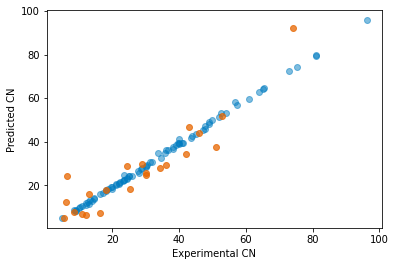

In [16]:
print('CN/YSI, CN:')
plt.clf()
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter(cn_train, [p[0] for p in preds_train], color=(0, 114/235, 178/235), alpha=0.5, label='Training Set')
plt.scatter(cn_test, [p[0] for p in preds_test], color=(213/235, 94/235, 0), alpha=0.75, label='Test Set')
plt.show()

CN/YSI, YSI:


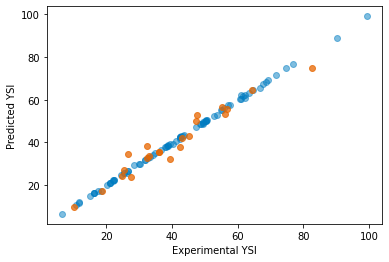

In [17]:
print('CN/YSI, YSI:')
plt.clf()
plt.xlabel('Experimental YSI')
plt.ylabel('Predicted YSI')
plt.scatter(ysi_train, [p[1] for p in preds_train], color=(0, 114/235, 178/235), alpha=0.5, label='Training Set')
plt.scatter(ysi_test, [p[1] for p in preds_test], color=(213/235, 94/235, 0), alpha=0.75, label='Test Set')
plt.show()

CN:


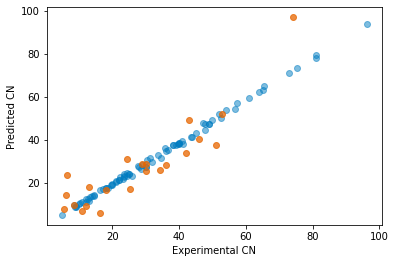

In [18]:
print('CN:')
plt.clf()
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter(cn_train, preds_train_cn, color=(0, 114/235, 178/235), alpha=0.5, label='Training Set')
plt.scatter(cn_test, preds_test_cn, color=(213/235, 94/235, 0), alpha=0.75, label='Test Set')
plt.show()

YSI:


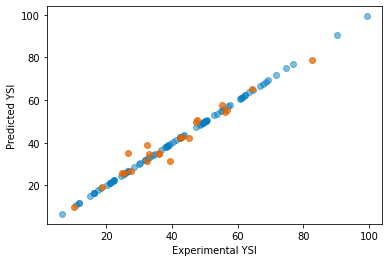

In [19]:
print('YSI:')
plt.clf()
plt.xlabel('Experimental YSI')
plt.ylabel('Predicted YSI')
plt.scatter(ysi_train, preds_train_ysi, color=(0, 114/235, 178/235), alpha=0.5, label='Training Set')
plt.scatter(ysi_test, preds_test_ysi, color=(213/235, 94/235, 0), alpha=0.75, label='Test Set')
plt.show()

In [20]:
test_maes_mcn = []
test_maes_mysi = []
test_maes_cn = []
test_maes_ysi = []

for i in range(100):

    print(f'Iteration {i + 1}')

    dv_train, dv_test, tar_train, tar_test = train_test_split(DESC_VALS, TARG_VALS, test_size=0.2, random_state=i)

    ds_train = QSPRDatasetFromValues(dv_train, tar_train)
    ds_test = QSPRDatasetFromValues(dv_test, tar_test)

    ds_train_cn = QSPRDatasetFromValues(dv_train, [[t[0]] for t in tar_train])
    ds_test_cn = QSPRDatasetFromValues(dv_test, [[t[0]] for t in tar_test])

    ds_train_ysi = QSPRDatasetFromValues(dv_train, [[t[1]] for t in tar_train])
    ds_test_ysi = QSPRDatasetFromValues(dv_test, [[t[1]] for t in tar_test])

    pca = PCA()
    pca.fit(ds_train.desc_vals.detach().numpy())

    ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
    ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

    ds_train_cn.desc_vals = ds_train.desc_vals
    ds_test_cn.desc_vals = ds_test.desc_vals
    ds_train_ysi.desc_vals = ds_train.desc_vals
    ds_test_ysi.desc_vals = ds_test.desc_vals

    ds_train.target_vals = ds_train.target_vals.type(torch.float32)
    ds_test.target_vals = ds_test.target_vals.type(torch.float32)
    ds_train_cn.target_vals = ds_train_cn.target_vals.type(torch.float32)
    ds_test_cn.target_vals = ds_test_cn.target_vals.type(torch.float32)
    ds_train_ysi.target_vals = ds_train_ysi.target_vals.type(torch.float32)
    ds_test_ysi.target_vals = ds_test_ysi.target_vals.type(torch.float32)

    model = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 3)
    model_cn = ECNet(ds_train_cn.desc_vals.shape[1], ds_train_cn.target_vals.shape[1], 512, 3)
    model_ysi = ECNet(ds_train_ysi.desc_vals.shape[1], ds_train_ysi.target_vals.shape[1], 512, 3)

    _, _ = model.fit(dataset=ds_train, epochs=256, valid_size=0.33, shuffle=True, patience=16, verbose=0, lr=0.001)

    pred_test = model(ds_test.desc_vals).detach().numpy()
    test_maes_mcn.append(median_absolute_error([t[0] for t in tar_test], [p[0] for p in pred_test]))
    test_maes_mysi.append(median_absolute_error([t[1] for t in tar_test], [p[1] for p in pred_test]))

    _, _ = model_cn.fit(dataset=ds_train_cn, epochs=256, valid_size=0.33, shuffle=True, patience=16, verbose=0, lr=0.001)

    pred_test = model_cn(ds_test.desc_vals).detach().numpy()
    test_maes_cn.append(median_absolute_error(ds_test_cn.target_vals.detach().numpy(), pred_test))

    _, _ = model_ysi.fit(dataset=ds_train_ysi, epochs=256, valid_size=0.33, shuffle=True, patience=16, verbose=0, lr=0.001)

    pred_test = model_ysi(ds_test.desc_vals).detach().numpy()
    test_maes_ysi.append(median_absolute_error(ds_test_ysi.target_vals.detach().numpy(), pred_test))

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

In [22]:
print(f'CN/YSI, CN: {np.mean(test_maes_mcn)} +/- {np.std(test_maes_mcn)}')
print(f'CN/YSI, YSI: {np.mean(test_maes_mysi)} +/- {np.std(test_maes_mysi)}')
print(f'CN: {np.mean(test_maes_cn)} +/- {np.std(test_maes_cn)}')
print(f'YSI: {np.mean(test_maes_ysi)} +/- {np.std(test_maes_ysi)}')

CN/YSI, CN: 5.094241803646088 +/- 1.1747833768058176
CN/YSI, YSI: 2.483336194038391 +/- 0.8804392252686305
CN: 5.2699198722839355 +/- 1.2351881265640259
YSI: 2.309030532836914 +/- 0.9803870320320129
